In [2]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/70/58/2f94976df39470fb00eec2cb4f914dde44cd0df8d96483208bf7db4bc97e/xgboost-2.1.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 325.1 kB/s eta 0:06:25
   ---------------------------------------- 0.0/124.9 MB 325.1 kB/s eta 0:06:25
   ---------------------------------------- 0.1/124.9 MB 393.8 kB/s eta 0:05:17
   ---------------------------------------- 0.6/124.9 MB 2.8 MB/s eta 0:00:45
   ---------------------------------------- 1.3/124.9 MB 5.1 MB/s eta 0:00:25
    --------------------------------------- 2.2/124.9 MB 7.2 MB/s eta 0:00:17
    --------------------------------------- 3.0/124.9 MB 8.7 MB/s eta 0:00:15
   - -------------------------

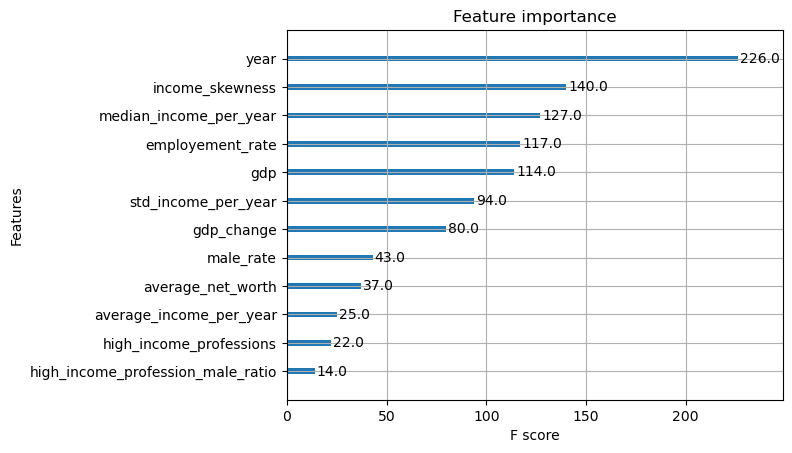

MAE: 0.006603144854307172, RMSE: 0.008818305289781534, R²: 0.8271277317102956
Predicted Gini for year 116: 0.4843
Predicted Gini for year 117: 0.4843
Predicted Gini for year 118: 0.4843
Predicted Gini for year 119: 0.4843
Predicted Gini for year 120: 0.4843


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your dataset (assuming you have Gini & other features by year)
df_person = pd.read_csv("data_island_tm_year115.csv")  # Replace with your actual dataset file
df = pd.read_csv("data_island_tm_year115_gdp.csv")

average_income_per_year = df_person.groupby("year")["income"].mean()
df["average_income_per_year"] = average_income_per_year.values

df["income_skewness"] = df_person.groupby("year")["income"].skew()

df["high_income_professions"] = df_person.groupby("year")["income"].apply(lambda x: (x > x.median()).mean())

std_income_per_year = df_person.groupby("year")["income"].std()
df["std_income_per_year"] = std_income_per_year.values

median_income_per_year = df_person.groupby("year")["income"].median()
df["median_income_per_year"] = median_income_per_year.values

employement_rate = df_person.groupby("year")["profession"].apply(lambda x: ((x != "retired") & (x != "child")).sum())
df["employement_rate"] = employement_rate.values

male_rate = df_person.groupby("year")["sex"].apply(lambda x: (x == "M").sum())
df["male_rate"] = male_rate.values

df["high_income_profession_rate"] = df_person.groupby("year").apply(
    lambda x: (x[x["income"] > x["income"].median()]["profession"].count()) / x["profession"].count()
)

df["high_income_profession_male_ratio"] = df["high_income_profession_rate"] * df["male_rate"]

df['average_net_worth'] = df_person.groupby("year")["net_worth"].mean()

df["gdp_change"] = df["gdp"].diff()


# Define features (X) and target variable (y)
X = df.drop(columns=["gini"])  # Remove target & time column
y = df["gini"]

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Plot feature importance
xgb.plot_importance(model)
plt.show()

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Predict Gini for the next 5 years
future_years = np.array([116, 117, 118, 119, 120])
future_data = pd.DataFrame({
    'year': future_years,
    'gdp': [df['gdp'].mean()] * len(future_years),
    'average_income_per_year': [df['average_income_per_year'].mean()] * len(future_years),
    'income_skewness': [df['income_skewness'].mean()] * len(future_years),
    'high_income_professions': [df['high_income_professions'].mean()] * len(future_years),
    'std_income_per_year': [df['std_income_per_year'].mean()] * len(future_years),
    'median_income_per_year': [df['median_income_per_year'].mean()] * len(future_years),
    'employement_rate': [df['employement_rate'].mean()] * len(future_years),
    'male_rate': [df['male_rate'].mean()] * len(future_years),
    'high_income_profession_rate': [df['high_income_profession_rate'].mean()] * len(future_years),
    'high_income_profession_male_ratio': [df['high_income_profession_male_ratio'].mean()] * len(future_years),
    'average_net_worth': [df['average_net_worth'].mean()] * len(future_years),
    'gdp_change': [df['gdp_change'].mean()] * len(future_years),
})

future_gini = model.predict(future_data)

# Print predictions
for year, gini in zip(future_years, future_gini):
    print(f"Predicted Gini for year {year}: {gini:.4f}")


In [46]:
df['average_happiness'] = df_person.groupby("year")["happiness"].mean()
print(df['average_happiness'])

0      100.000000
1       99.453518
2       99.134510
3      100.174863
4      100.823860
          ...    
111     99.951952
112    100.386362
113    100.546966
114    101.859254
115    101.258020
Name: average_happiness, Length: 116, dtype: float64